# Create_df_from_filter_quad_scan

In [1]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
from skimage import filters
from scipy import integrate
import logging
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [2]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

def create_elliptical_mask(h, w, center=None, radius=None, a=None, b=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt( ((X - center[0])**2)/(a**2) + ((Y-center[1])**2)/(b**2) )

    mask = dist_from_center <= radius
    return mask

def interpolate_gradient(current, magnet_type):
	A_Q74L = [5.000978,
			  10.000304,
			  50.002003,
			  100.001404,
			  150.001373,
			  200.00238,
			  250.005432,
			  299.993652,
			  350.001648,
			  399.995728,
			  449.994446,
			  499.997375,
			  549.999878,
			  599.994873,
			  650.004211,
			  666.999146,
			  699.991455,
			  749.998169,
			  799.996643]

	T_Q74L = [0.2619,
			  0.492968,
			  2.358847,
			  4.710821,
			  7.068205,
			  9.426532,
			  11.780794,
			  14.131984,
			  16.4773,
			  18.814776,
			  21.133094,
			  23.416058,
			  25.617934,
			  27.638804,
			  29.43015,
			  29.981004,
			  30.987122,
			  32.347211,
			  33.545971]

	A_Q120C = [0.00,
			   50.00,
			   100.00,
			   150.00,
			   200.00,
			   250.00,
			   300.00,
			   350.00,
			   400.00,
			   450.00,
			   500.00,
			   550.00,
			   600.00,
			   650.00]

	T_Q120C = [0.00,
			   2.05,
			   4.12,
			   6.19,
			   8.26,
			   10.33,
			   12.39,
			   14.43,
			   16.44,
			   18.36,
			   20.14,
			   21.74,
			   23.01,
			   24.07]

	A_QFL = [0,
			 94.15,
			 145.76,
			 197.97,
			 250.74,
			 300.18,
			 350.7,
			 402,
			 451.15,
			 502.09,
			 551.47]

	T_QFL = [0,
			 4.86,
			 7.48,
			 10.158,
			 12.875,
			 15.377,
			 17.81,
			 20.045,
			 21.844,
			 23.217,
			 24.445]

	if magnet_type == "Q74L":
		measured_currents = A_Q74L
		measured_int_gradient = T_Q74L
	if magnet_type == "Q120C":
		measured_currents = A_Q120C
		measured_int_gradient = T_Q120C
	if magnet_type == "QFL":
		measured_currents = A_QFL
		measured_int_gradient = T_QFL

	# Make the curve symmetric
	if (current < 0):
		interpolated_int_gradient = -np.interp(-current, measured_currents, measured_int_gradient)
	else:
		interpolated_int_gradient = np.interp(current, measured_currents, measured_int_gradient)

	return interpolated_int_gradient

# Filter measurement

In [3]:
start_path = "/eos/user/e/eljohnso/SWAN_projects/"
# end_path = "quad_scan_east_dump_with_filters_data/"
end_path = "quad_scan_t8_data/"
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [4]:
dirnames

['quad_scan_t8_2022_07_13_14h58m48s',
 'quad_scan_t8_2022_07_13_15h15m02s',
 'quad_scan_t8_2022_07_13_15h36m47s',
 'quad_scan_t8_2022_07_13_16h20m49s']

In [5]:
# Take the last image
subset_dirnames = [dirnames[2]]
subset_dirnames

['quad_scan_t8_2022_07_13_15h36m47s']

In [6]:
btv_name = "T8.BTV096/Image"
df = pd.DataFrame(data = {"time": [], "Image": [], "Image_processed": [], "Acqu": [], "Intensity": [], "Filter": [], "sigmaSet1": [],
                          "i_qfn01": [], "i_qdn02": [], "i_qfn03": [],
                          "k_qfn01": [], "k_qdn02": [], "k_qfn03": [],
                          #"i_func_qfn01": [],
#                           "i_func_qdn02": [],
#                           "i_func_qfn03": [],
#                           "i_oasis_qfn01": [], "i_oasis_qdn02": [], "i_oasis_qfn03": [],
                         })
for dirname in subset_dirnames:
    print (dirname)
    infile = open(start_path+end_path+"/"+dirname+"/"+dirname+".p", 'rb')
    loaded_pickle = pickle.load(infile)
    
    pixel_y = len(loaded_pickle[2][btv_name][0]["imagePositionSet2"][0])

    for j in range(len(loaded_pickle[0])):
        for i in range(6):
            try:
                image = loaded_pickle[2][btv_name][j]["imageSet"][i]
                reshaped_image = image.reshape(pixel_y,-1)
                reshaped_image = reshaped_image/4095 #Normalize
                med_filter_image = filters.median(reshaped_image, np.ones((3, 3)))

                try:
                    df2 = pd.DataFrame(data = {"time": loaded_pickle[0][j],
                                                "Image": [reshaped_image], "Image_processed": [med_filter_image], "Acqu": [i],
                                               "Intensity": [loaded_pickle[5][j]],
#                                                "Filter": [loaded_pickle[2][btv_name][j]["filterSelect"][1]],
                                               "sigmaSet1": loaded_pickle[2][btv_name][j]["sigmaSet1"][i],
                                               "i_qfn01": loaded_pickle[3]["F61.QFN01/MEAS.PULSE#VALUE"][j],
                                               "i_qdn02": loaded_pickle[3]["F61.QDN02/MEAS.PULSE#VALUE"][j],
                                               "i_qfn03": loaded_pickle[3]["F61.QFN03/MEAS.PULSE#VALUE"][j],
                                               "k_qfn01": loaded_pickle[4]["logical.F61.QFN01/K_FUNC_LIST#value"][j][0][1][0],
                                               "k_qdn02": loaded_pickle[4]["logical.F61.QDN02/K_FUNC_LIST#value"][j][0][1][0],
                                               "k_qfn03": loaded_pickle[4]["logical.F61.QFN03/K_FUNC_LIST#value"][j][0][1][0],
    #                                            "i_func_qfn01": loaded_pickle[6]["logical.F61.QFN01/I_FUNC_LIST#value"][j][0],
#                                                "i_func_qdn02": [loaded_pickle[6]["logical.F61.QDN02/I_FUNC_LIST#value"][j][0]],
#                                                "i_func_qfn03": [loaded_pickle[6]["logical.F61.QFN03/I_FUNC_LIST#value"][j][0]],
#                                                "i_oasis_qfn01": [loaded_pickle[7]["F61.QFN01/LOG.OASIS.I_MEAS#DATA"][j]],
#                                                "i_oasis_qdn02": [loaded_pickle[7]["F61.QDN02/LOG.OASIS.I_MEAS#DATA"][j]],
#                                                "i_oasis_qfn03": [loaded_pickle[7]["F61.QFN03/LOG.OASIS.I_MEAS#DATA"][j]],
                                              })
                except:
                    print("here")
                df = pd.concat([df,df2])
            except:
                print("error")
                pass
df.reset_index(drop=True, inplace=True)

# Add saturation colum
saturation_list = []
for i in range(len(df)):
    saturation_list.append((df.iloc[i].Image == 1).sum())
df["Saturation"] = saturation_list
saturation_list = []
for i in range(len(df)):
    saturation_list.append((df.iloc[i].Image_processed == 255).sum())
df["Saturation_processed"] = saturation_list
    
df.head(5)

quad_scan_t8_2022_07_13_15h36m47s


/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/skimage/util/dtype.py:140: UserWarning: Possible precision loss when converting from float64 to uint8
  warn("Possible precision loss when converting from {} to {}"


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


time  \
0 2022-07-13 15:36:56.561514   
1 2022-07-13 15:36:56.561514   
2 2022-07-13 15:36:56.561514   
3 2022-07-13 15:36:56.561514   
4 2022-07-13 15:36:56.561514   

                                               Image  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.048840048840...   
1  [[0.0, 0.0, 0.010256410256410256, 0.0949938949...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0009768009768009768, 0.0903...   
4  [[0.0002442002442002442, 0.0004884004884004884...   

                                     Image_processed  Acqu  Intensity  Filter  \
0  [[17, 11, 1, 1, 1, 2, 2, 12, 10, 8, 8, 1, 0, 0...   0.0   59.95916     NaN   
1  [[10, 6, 6, 7, 21, 21, 21, 27, 27, 24, 20, 18,...   1.0   59.95916     NaN   
2  [[0, 0, 0, 0, 0, 0, 0, 1, 11, 11, 16, 17, 16, ...   2.0   59.95916     NaN   
3  [[0, 0, 0, 0, 1, 23, 19, 14, 7, 4, 4, 4, 2, 0,...   3.0   59.95916     NaN   
4  [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   4.0   59.95916     NaN   

    sigmaSet1     i_qfn01   i_qdn02   i_qfn03  k_qfn01  k_qdn02  k_qfn03  \
0   35.052376  400.434723  0.001548 -0.001199    0.317      0.0      0.0   
1    5.691923  400.434723  0.001548 -0.001199    0.317      0.0      0.0   
2    0.959836  400.434723  0.001548 -0.001199    0.317      0.0      0.0   
3  883.959369  400.434723  0.001548 -0.001199    0.317      0.0      0.0   
4    0.354893  400.434723  0.001548 -0.001199    0.317      0.0      0.0   

   Saturation  Saturation_processed  
0           0                     0  
1           0                     0  
2           0                     0  
3           0                     0  
4           0                     0

In [7]:
# Add fitting colums
gaussian_maxH_list = []
gaussian_maxV_list = []

poptH0_list = []
poptH1_list = []
poptH2_list = []
poptH3_list = []

poptV0_list = []
poptV1_list = []
poptV2_list = []
poptV3_list = []

muH_list = []
muH_err_list = []
muV_list = []
muV_err_list = []

sigH_list = []
sigH_err_list = []
sigV_list = []
sigV_err_list = []

integralH_list = []
integralV_list = []


for i in range(len(df)):

    try:
        Image_processed = df.iloc[i].Image_processed.copy()

        Hy = Image_processed.sum(axis=0)
        Hx = np.linspace(0, len(Hy)-1, len(Hy))

        Vy = Image_processed.sum(axis=1)
        Vx = np.linspace(0, len(Vy)-1, len(Vy))

        # H
        poptH, pcovH = do_gaussian_fit(Hx, Hy)

        gaussian_maxH = gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]).max()

        # V
        poptV, pcovV = do_gaussian_fit(Vx, Vy)

        gaussian_maxV = gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]).max()

        gaussian_maxH_list.append(gaussian_maxH)
        gaussian_maxV_list.append(gaussian_maxV)
        
        poptH0_list.append(poptH[0])
        poptH1_list.append(poptH[1])
        poptH2_list.append(poptH[2])
        poptH3_list.append(poptH[3])
        
        poptV0_list.append(poptV[0])
        poptV1_list.append(poptV[1])
        poptV2_list.append(poptV[2])
        poptV3_list.append(poptV[3])

        
        muH_list.append(poptH[2])
        muH_err_list.append(pcovH[2, 2] ** 0.5)
        muV_list.append(poptV[2])
        muV_err_list.append(pcovV[2, 2] ** 0.5)
        
        sigH_list.append(poptH[3])
        sigH_err_list.append(pcovH[3, 3] ** 0.5)
        sigV_list.append(poptV[3])
        sigV_err_list.append(pcovV[3, 3] ** 0.5)
        
        try:
            #Integration
            x = np.linspace(0,300,300)
            gaussH = lambda x: gaussian_function(x, poptH[0], poptH[1], poptH[2], poptH[3])
            integralH = (integrate.quad(gaussH, 0, 300))

            gaussV = lambda x: gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
            integralV = (integrate.quad(gaussV, 0, 300))

            integralH_list.append(integralH[0])
            integralV_list.append(integralV[0])
        except:
            print("failed integration")
            pass
            
        
    except:
        gaussian_maxH_list.append(np.nan)
        gaussian_maxV_list.append(np.nan)

        poptH0_list.append(np.nan)
        poptH1_list.append(np.nan)
        poptH2_list.append(np.nan)
        poptH3_list.append(np.nan)
        
        poptV0_list.append(np.nan)
        poptV1_list.append(np.nan)
        poptV2_list.append(np.nan)
        poptV3_list.append(np.nan)
        
        muH_list.append(np.nan)
        muH_err_list.append(np.nan)
        muV_list.append(np.nan)
        muV_err_list.append(np.nan)
        
        sigH_list.append(np.nan)
        sigH_err_list.append(np.nan)
        sigV_list.append(np.nan)
        sigV_err_list.append(np.nan)
        
        integralH_list.append(np.nan)
        integralV_list.append(np.nan)
#         print("Failed fit")

# df["gaussian_maxH_proc"] = gaussian_maxH_list
# df["gaussian_maxV_proc"] = gaussian_maxV_list

# df["poptH0_proc"] = poptH0_list
# df["poptH1_proc"] = poptH1_list
# df["poptH2_proc"] = poptH2_list
# df["poptH3_proc"] = poptH3_list
df["muH_proc"] = muH_list
df["muErrH_proc"] = muH_err_list
df["sigH_proc"] = sigH_list
df["sigErrH_proc"] = sigH_err_list


# df["poptV0_proc"] = poptV0_list
# df["poptV1_proc"] = poptV1_list
# df["poptV2_proc"] = poptV2_list
# df["poptV3_proc"] = poptV3_list
df["muV_proc"] = muV_list
df["muErrV_proc"] = muV_err_list
df["sigV_proc"] = sigV_list
df["sigErrV_proc"] = sigV_err_list

# df["integralH_proc"] = integralH_list
# df["integralV_proc"] = integralV_list
print (f"{len(df[np.isnan(df.muH_proc)].muH_proc)}/{len(df)} failed fit")

print (f"muH: {int(df.muH_proc.median())}")
print (f"muV: {int(df.muV_proc.median())}")
print (f"sigH: {int(df.sigH_proc.median())}")
print (f"sigV: {int(df.sigV_proc.median())}")

32/252 failed fit
muH: 54
muV: 81
sigH: 67
sigV: 21


# Add a column with automatically adjusted mask from first fit

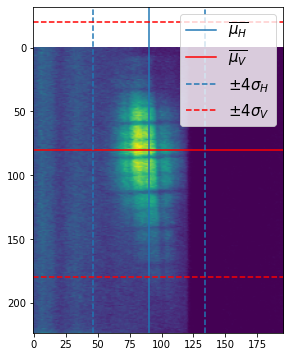

In [8]:
# fig, ax = plt.subplots(figsize=(10,6))
# i = 99
# ax.imshow(df.loc[i].Image)

sum_image = np.zeros(shape=(224, 196))
for i in range(len(df)):
    sum_image = sum_image + df.iloc[i].Image
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(sum_image)

# muH_median = df.iloc[i].muH_proc
# muV_median = df.iloc[i].muV_proc
# sigH_median = df.iloc[i].sigH_proc
# sigV_median = df.iloc[i].sigV_proc

#Override the mask
muH_median = 90
muV_median = 80
sigH_median = 11
sigV_median = 25

ax.axvline(muH_median, label = "$\overline{\mu_{H}}$")
ax.axhline(muV_median, color="r", label = "$\overline{\mu_{V}}$")

ax.axvline(muH_median + 4*sigH_median, linestyle="--", label="$\pm4{\sigma_{H}}$")
ax.axvline(muH_median - 4*sigH_median, linestyle="--")

ax.axhline(muV_median + 4*sigV_median, linestyle="--", color="r", label="$\pm4{\sigma_{V}}$")
ax.axhline(muV_median - 4*sigV_median, linestyle="--", color="r")

ax.legend(fontsize=15)

In [9]:
sum_image = np.zeros(shape=(224, 196))
for i in range(20):
    sum_image = sum_image + df.iloc[150+i].Image
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(sum_image)

#Override the mask
muH_median = 87
muV_median = 73
sigH_median = 11
sigV_median = 16

ax.axvline(muH_median, label = "$\overline{\mu_{H}}$")
ax.axhline(muV_median, color="r", label = "$\overline{\mu_{V}}$")

ax.axvline(muH_median + 4*sigH_median, linestyle="--", label="$\pm4{\sigma_{H}}$")
ax.axvline(muH_median - 4*sigH_median, linestyle="--")

ax.axhline(muV_median + 4*sigV_median, linestyle="--", color="r", label="$\pm4{\sigma_{V}}$")
ax.axhline(muV_median - 4*sigV_median, linestyle="--", color="r")

ax.legend(fontsize=15)

In [10]:
# Add masked colum
image_processed_masked_list = []
for i in range(len(df)):
    
    image_processed_masked = df.iloc[i].Image_processed.copy()
    
    h, w = image_processed_masked.shape[:2]
#     mask = create_elliptical_mask(h, w, center=(df.iloc[i].muH_proc,df.iloc[i].muV_proc), radius = 1, a=2*df.iloc[i].sigH_proc, b=2*df.iloc[i].sigV_proc)

    if (i<50):
        muH_median = 100
        muV_median = 80
        sigH_median = 7
        sigV_median = 14
    if (i>=50 and i<100):
        muH_median = 78
        muV_median = 60
        sigH_median = 7
        sigV_median = 14
    if (i>=100 and i<150):
        muH_median = 85
        muV_median = 55
        sigH_median = 7
        sigV_median = 14
    if (i>=150 and i<200):    
        muH_median = 89
        muV_median = 71
        sigH_median = 11
        sigV_median = 17
    if (i>=200 and i<230):  
        muH_median = 90
        muV_median = 120
        sigH_median = 9
        sigV_median = 22
    if (i>=230):
        muH_median = 98
        muV_median = 150
        sigH_median = 9
        sigV_median = 22

    #Override the mask
    mask = create_elliptical_mask(h, w, center=(muH_median, muV_median), radius = 1, a=4*sigH_median, b=4*sigV_median)
    masked_img = image_processed_masked.copy()
    masked_img[~mask] = 0

    image_processed_masked_list.append(masked_img)
    
df["Image_processed_masked"] = image_processed_masked_list
df.head(1)

time  \
0 2022-07-13 15:36:56.561514   

                                               Image  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.048840048840...   

                                     Image_processed  Acqu  Intensity  Filter  \
0  [[17, 11, 1, 1, 1, 2, 2, 12, 10, 8, 8, 1, 0, 0...   0.0   59.95916     NaN   

   sigmaSet1     i_qfn01   i_qdn02   i_qfn03  ...  Saturation_processed  \
0  35.052376  400.434723  0.001548 -0.001199  ...                     0   

    muH_proc  muErrH_proc  sigH_proc  sigErrH_proc   muV_proc  muErrV_proc  \
0  44.619945     7.849216  94.914745     30.012933  144.49718     5.113322   

   sigV_proc  sigErrV_proc                             Image_processed_masked  
0  25.154441      6.195913  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[1 rows x 24 columns]

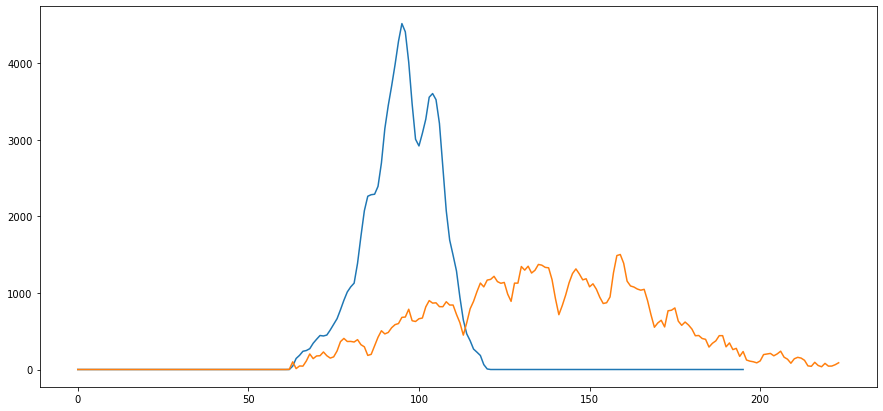

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df.iloc[238].Image_processed_masked.sum(axis=0))
ax.plot(df.iloc[238].Image_processed_masked.sum(axis=1))

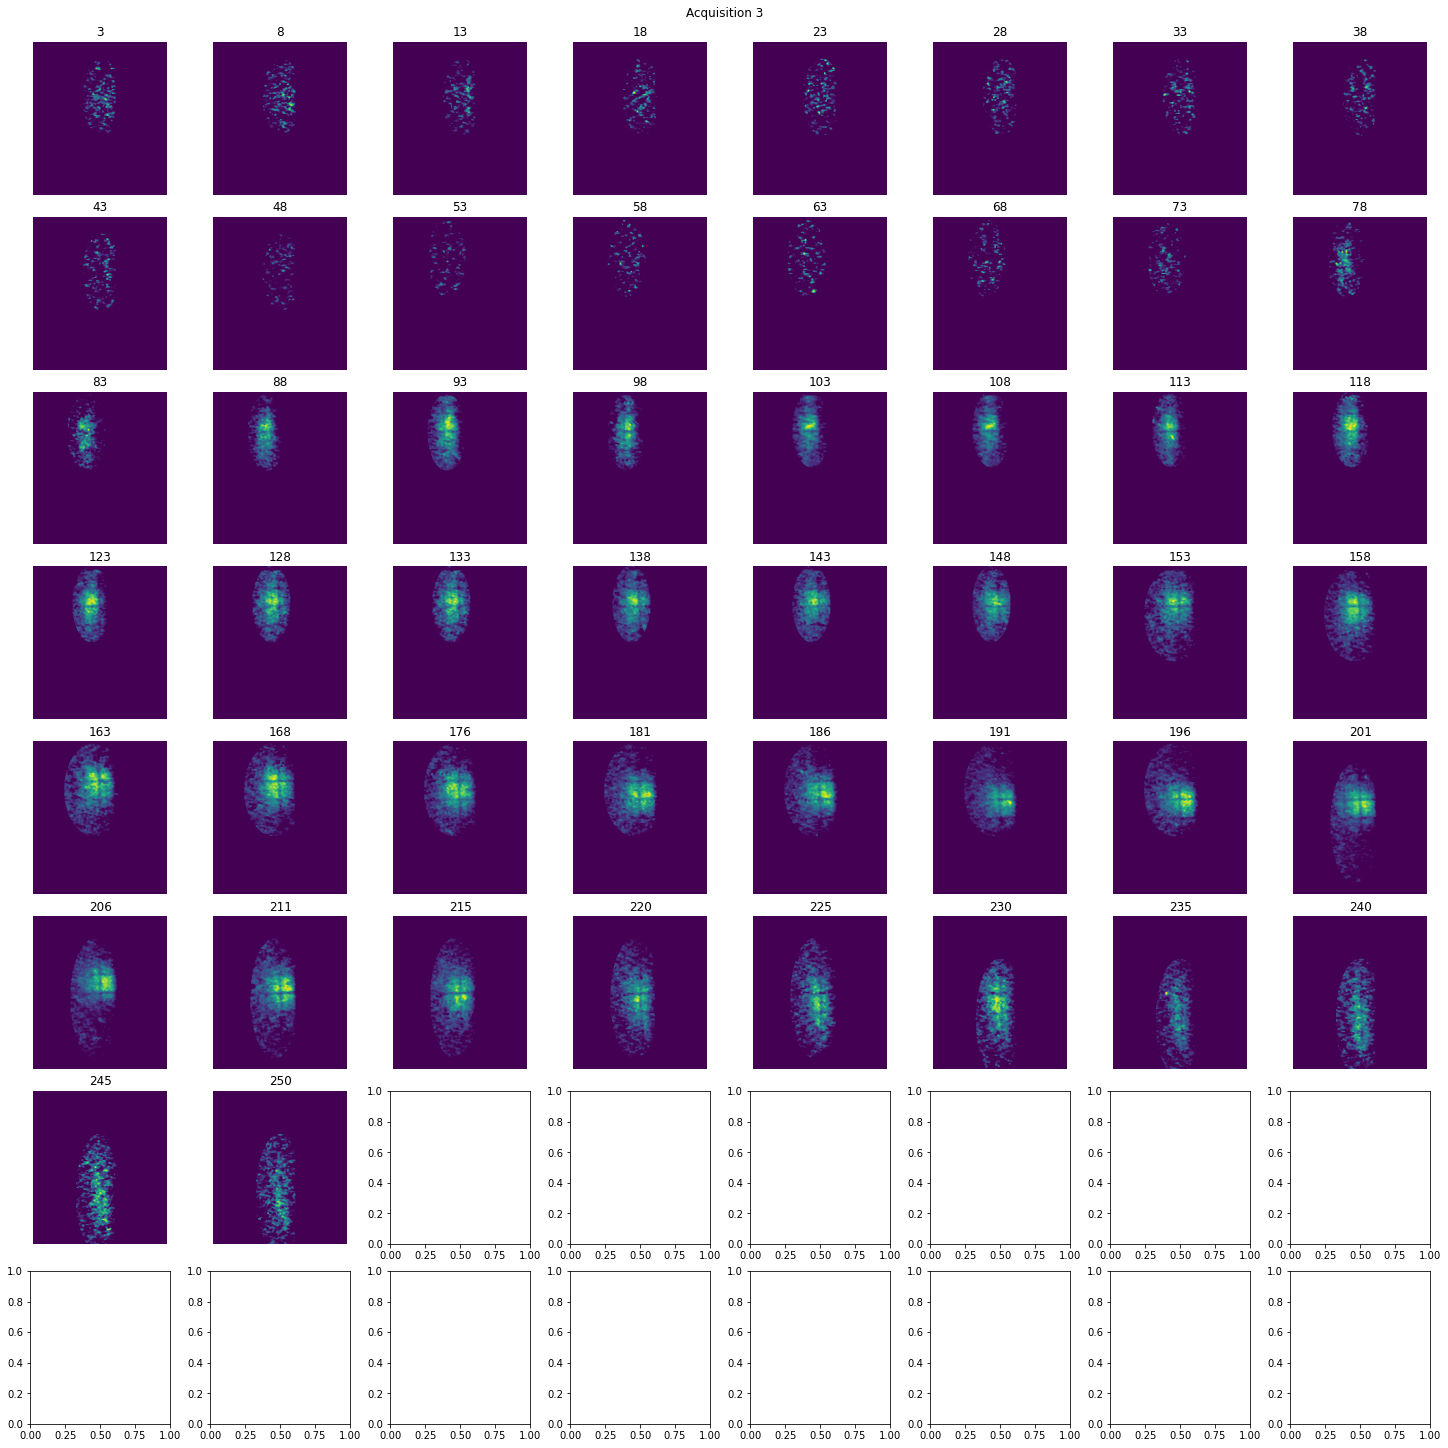

In [12]:
df_acq = df[df.Acqu==3].copy()
# df_acq = df.copy()

# fig, ax = plt.subplots(16, 16, figsize=(20,20),constrained_layout=True)
# fig.suptitle(f"Acquisition {3}")
# for i in range(len(df_acq)):
#     ax[i//16,i%16].imshow(df_acq.iloc[i].Image_processed_masked)
#     ax[i//16,i%16].set_axis_off()
#     ax[i//16,i%16].set_title(f"{i}")

fig, ax = plt.subplots(8, 8, figsize=(20,20),constrained_layout=True)
fig.suptitle(f"Acquisition {3}")
for i in range(len(df_acq)):
    ax[i//8,i%8].imshow(df_acq.iloc[i].Image_processed_masked)
    ax[i//8,i%8].set_axis_off()
    ax[i//8, i%8].set_title(f"{df_acq.iloc[i].name}")

# Add fit for Image_processed_masked

In [13]:
# Add fitting colums
gaussian_maxH_list = []
gaussian_maxV_list = []

poptH0_list = []
poptH1_list = []
poptH2_list = []
poptH3_list = []

poptV0_list = []
poptV1_list = []
poptV2_list = []
poptV3_list = []

muH_list = []
muH_err_list = []
muV_list = []
muV_err_list = []

sigH_list = []
sigH_err_list = []
sigV_list = []
sigV_err_list = []

integralH_list = []
integralV_list = []


for i in range(len(df)):

    try:
        image_processed_masked = df.iloc[i].Image_processed_masked.copy()

        Hy = image_processed_masked.sum(axis=0)
        Hx = np.linspace(0, len(Hy)-1, len(Hy))

        Vy = image_processed_masked.sum(axis=1)
        Vx = np.linspace(0, len(Vy)-1, len(Vy))

        # H
        poptH, pcovH = do_gaussian_fit(Hx, Hy)

        gaussian_maxH = gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]).max()

        # V
        poptV, pcovV = do_gaussian_fit(Vx, Vy)

        gaussian_maxV = gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]).max()

        gaussian_maxH_list.append(gaussian_maxH)
        gaussian_maxV_list.append(gaussian_maxV)
        
        poptH0_list.append(poptH[0])
        poptH1_list.append(poptH[1])
        poptH2_list.append(poptH[2])
        poptH3_list.append(poptH[3])
        
        poptV0_list.append(poptV[0])
        poptV1_list.append(poptV[1])
        poptV2_list.append(poptV[2])
        poptV3_list.append(poptV[3])

        
        muH_list.append(poptH[2])
        muH_err_list.append(pcovH[2, 2] ** 0.5)
        muV_list.append(poptV[2])
        muV_err_list.append(pcovV[2, 2] ** 0.5)
        
        sigH_list.append(poptH[3])
        sigH_err_list.append(pcovH[3, 3] ** 0.5)
        sigV_list.append(poptV[3])
        sigV_err_list.append(pcovV[3, 3] ** 0.5)
        
        try:
            #Integration
            x = np.linspace(-300,300,300)
            gaussH = lambda x: gaussian_function(x, poptH[0], poptH[1], poptH[2], poptH[3])
            integralH = (integrate.quad(gaussH, -300, 300))

            gaussV = lambda x: gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
            integralV = (integrate.quad(gaussV, -300, 300))

            integralH_list.append(integralH[0])
            integralV_list.append(integralV[0])
        except:
            print("failed integration")
            pass
            
        
    except:
        gaussian_maxH_list.append(np.nan)
        gaussian_maxV_list.append(np.nan)

        poptH0_list.append(np.nan)
        poptH1_list.append(np.nan)
        poptH2_list.append(np.nan)
        poptH3_list.append(np.nan)
        
        poptV0_list.append(np.nan)
        poptV1_list.append(np.nan)
        poptV2_list.append(np.nan)
        poptV3_list.append(np.nan)
        
        muH_list.append(np.nan)
        muH_err_list.append(np.nan)
        muV_list.append(np.nan)
        muV_err_list.append(np.nan)
        
        sigH_list.append(np.nan)
        sigH_err_list.append(np.nan)
        sigV_list.append(np.nan)
        sigV_err_list.append(np.nan)
        
        integralH_list.append(np.nan)
        integralV_list.append(np.nan)
#         print("Failed fit")

df["gaussian_maxH"] = gaussian_maxH_list
df["gaussian_maxV"] = gaussian_maxV_list

df["poptH0"] = poptH0_list
df["poptH1"] = poptH1_list
df["poptH2"] = poptH2_list
df["poptH3"] = poptH3_list
df["muH"] = muH_list
df["muErrH"] = muH_err_list
df["sigH"] = sigH_list
df["sigErrH"] = sigH_err_list


df["poptV0"] = poptV0_list
df["poptV1"] = poptV1_list
df["poptV2"] = poptV2_list
df["poptV3"] = poptV3_list
df["muV"] = muV_list
df["muErrV"] = muV_err_list
df["sigV"] = sigV_list
df["sigErrV"] = sigV_err_list

df["integralH"] = integralH_list
df["integralV"] = integralV_list

print (f"{len(df[np.isnan(df.muH)].muH_proc)}/{len(df)} failed fit")

0/252 failed fit


# Fit with pixel calibration

In [14]:
# Add fitting colums
gaussian_maxH_list = []
gaussian_maxV_list = []

poptH0_list = []
poptH1_list = []
poptH2_list = []
poptH3_list = []

poptV0_list = []
poptV1_list = []
poptV2_list = []
poptV3_list = []

muH_list = []
muH_err_list = []
muV_list = []
muV_err_list = []

sigH_list = []
sigH_err_list = []
sigV_list = []
sigV_err_list = []

integralH_list = []
integralV_list = []


for i in range(len(df)):

    try:
        image_processed_masked = df.iloc[i].Image_processed_masked.copy()

        Hy = image_processed_masked.sum(axis=0)
        Hx = np.linspace(min(loaded_pickle[1]["T8.BTV096/Acquisition"][0]["projPositionSet1"][0]), max(loaded_pickle[1]["T8.BTV096/Acquisition"][0]["projPositionSet1"][0]), len(image_processed_masked.sum(axis=0))) # Pixel calibration

        Vy = image_processed_masked.sum(axis=1)
        Vx = np.linspace(min(loaded_pickle[1]["T8.BTV096/Acquisition"][0]["projPositionSet2"][0]), max(loaded_pickle[1]["T8.BTV096/Acquisition"][0]["projPositionSet2"][0]), len(image_processed_masked.sum(axis=1)))

        # H
        poptH, pcovH = do_gaussian_fit(Hx, Hy)

        gaussian_maxH = gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]).max()

        # V
        poptV, pcovV = do_gaussian_fit(Vx, Vy)

        gaussian_maxV = gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]).max()

        gaussian_maxH_list.append(gaussian_maxH)
        gaussian_maxV_list.append(gaussian_maxV)
        
        poptH0_list.append(poptH[0])
        poptH1_list.append(poptH[1])
        poptH2_list.append(poptH[2])
        poptH3_list.append(poptH[3])
        
        poptV0_list.append(poptV[0])
        poptV1_list.append(poptV[1])
        poptV2_list.append(poptV[2])
        poptV3_list.append(poptV[3])

        
        muH_list.append(poptH[2])
        muH_err_list.append(pcovH[2, 2] ** 0.5)
        muV_list.append(poptV[2])
        muV_err_list.append(pcovV[2, 2] ** 0.5)
        
        sigH_list.append(poptH[3])
        sigH_err_list.append(pcovH[3, 3] ** 0.5)
        sigV_list.append(poptV[3])
        sigV_err_list.append(pcovV[3, 3] ** 0.5)
                   
        
    except:
        gaussian_maxH_list.append(np.nan)
        gaussian_maxV_list.append(np.nan)

        poptH0_list.append(np.nan)
        poptH1_list.append(np.nan)
        poptH2_list.append(np.nan)
        poptH3_list.append(np.nan)
        
        poptV0_list.append(np.nan)
        poptV1_list.append(np.nan)
        poptV2_list.append(np.nan)
        poptV3_list.append(np.nan)
        
        muH_list.append(np.nan)
        muH_err_list.append(np.nan)
        muV_list.append(np.nan)
        muV_err_list.append(np.nan)
        
        sigH_list.append(np.nan)
        sigH_err_list.append(np.nan)
        sigV_list.append(np.nan)
        sigV_err_list.append(np.nan)
        
        integralH_list.append(np.nan)
        integralV_list.append(np.nan)
#         print("Failed fit")

# df["gaussian_maxH"] = gaussian_maxH_list
# df["gaussian_maxV"] = gaussian_maxV_list

df["poptH0_cal"] = poptH0_list
df["poptH1_cal"] = poptH1_list
df["poptH2_cal"] = poptH2_list
df["poptH3_cal"] = poptH3_list
# df["muH"] = muH_list
# df["muErrH"] = muH_err_list
# df["sigH"] = sigH_list
df["sigErrH_cal"] = sigH_err_list


df["poptV0_cal"] = poptV0_list
df["poptV1_cal"] = poptV1_list
df["poptV2_cal"] = poptV2_list
df["poptV3_cal"] = poptV3_list
# df["muV"] = muV_list
# df["muErrV"] = muV_err_list
# df["sigV"] = sigV_list
df["sigErrV_cal"] = sigV_err_list

# df["integralH"] = integralH_list
# df["integralV"] = integralV_list

print (f"{len(df[np.isnan(df.poptH3_cal)].poptH3_cal)}/{len(df)} failed fit")

0/252 failed fit


# Look at data

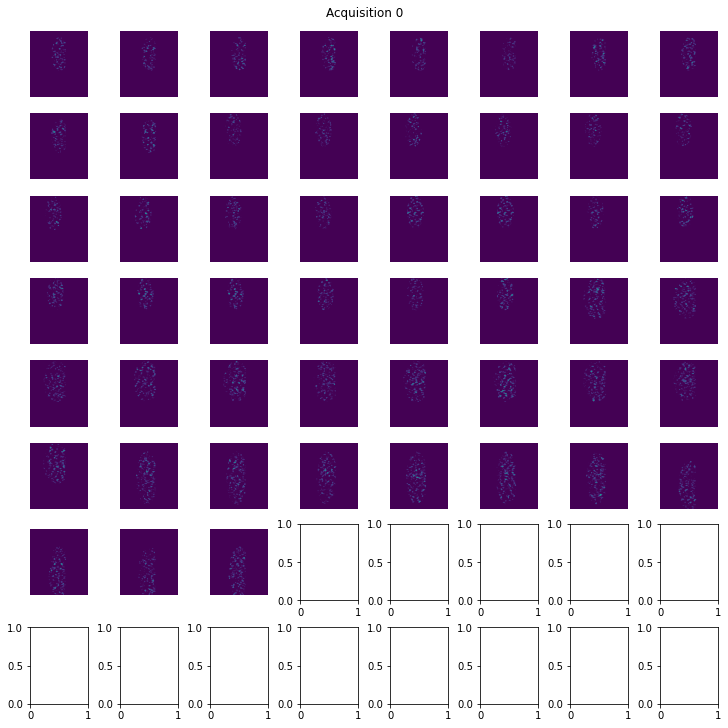

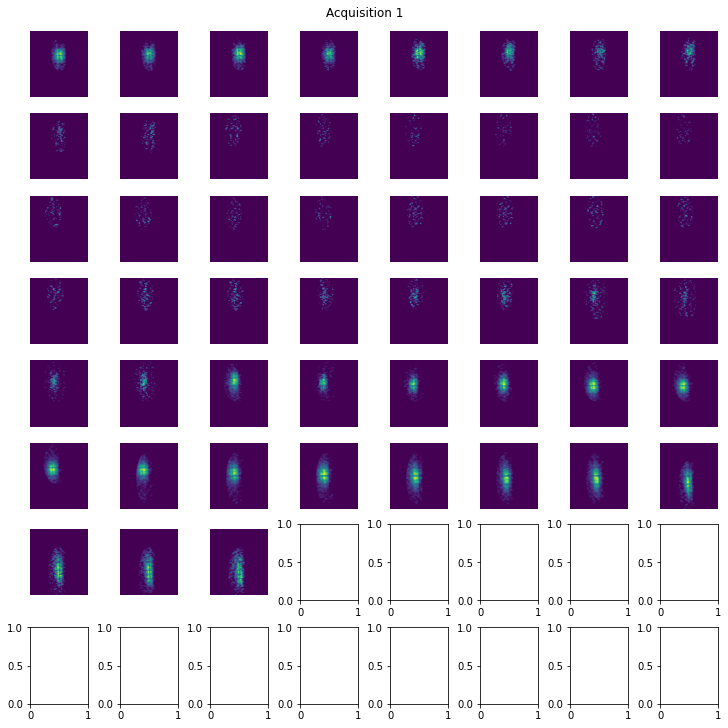

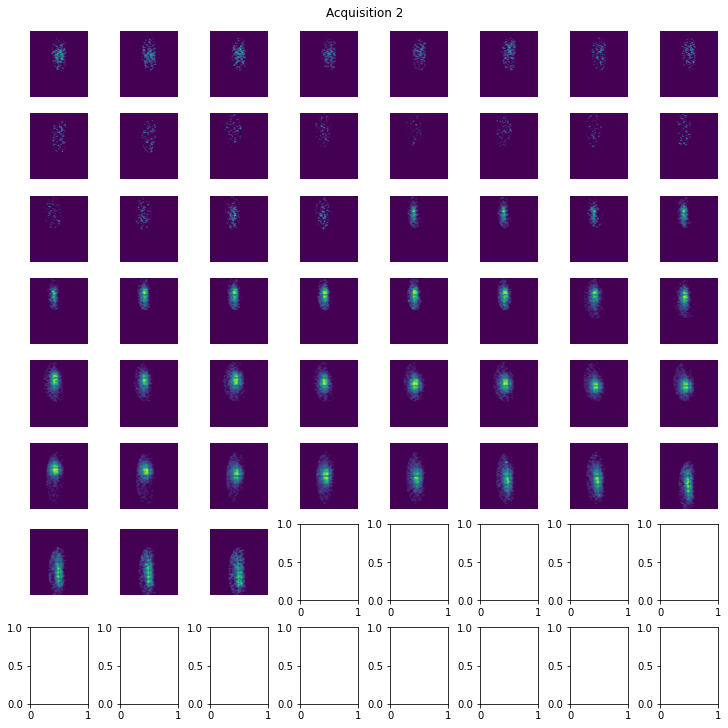

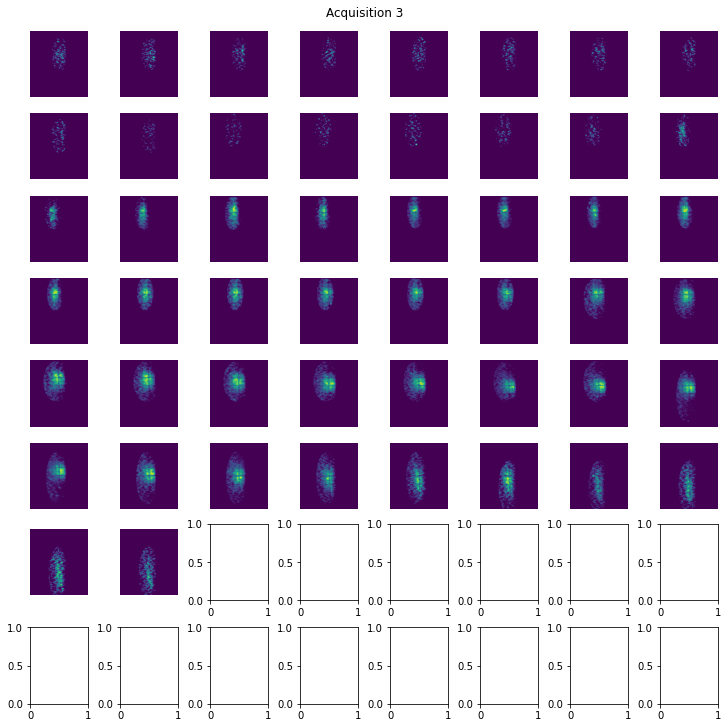

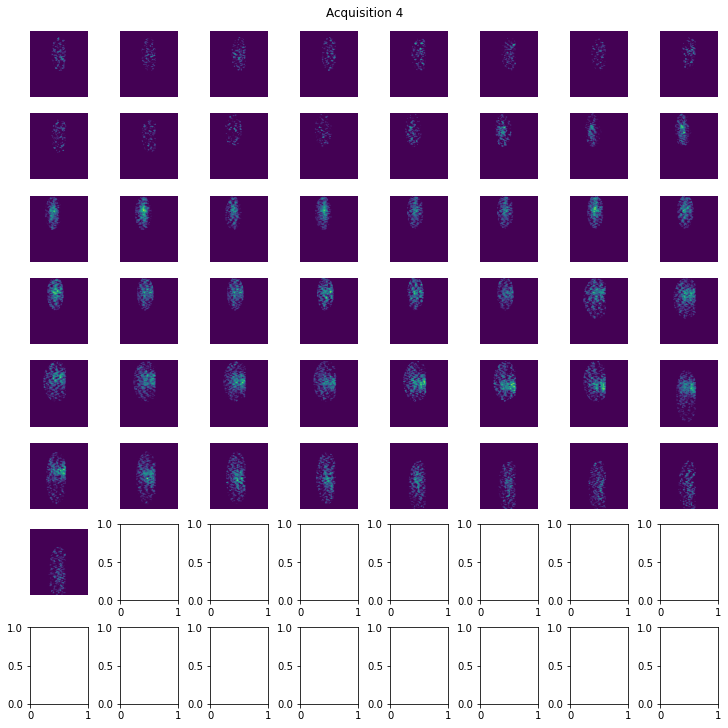

In [15]:
for acq in range(5):
    df_acq = df[df.Acqu==acq].copy()

    fig, ax = plt.subplots(8, 8, figsize=(10,10),constrained_layout=True)
    fig.suptitle(f"Acquisition {acq}")
    for i in range(len(df_acq)):
        ax[i//8,i%8].imshow(df_acq.iloc[i].Image_processed_masked)
        ax[i//8,i%8].set_axis_off()

In [16]:
import pickle

madxdf = pickle.load( open( "/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/madx_df.pickle", "rb" ) )

In [17]:
fig, ax = plt.subplots(1,3, figsize=(25,8))

# df_acq = df[df.Acqu==1].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="slategray", label="Acq 1")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="salmon", label="Acq 1")

# df_acq = df[df.Acqu==2].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="cornflowerblue", label="Acq 2", zorder=99)
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="tomato", label="Acq 2", zorder=99)

df_acq = df[df.Acqu==3].copy()
ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="blue", label="Acq 3")
ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="red", label="Acq 3")

df_acq = df[df.Acqu==4].copy()
ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="darkblue", label="Acq 4")
ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="darkred", label="Acq 4")

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("K QFN01 [A]")
ax[0].set_ylabel("H beam size $1\sigma$ [mm]")

ax[1].set_xlabel("K QFN01 [A]")
ax[1].set_ylabel("V beam size $1\sigma$ [mm]")
# ax[1].set_ylim(0, 60)

df_acq.reset_index(drop=True, inplace=True)
ax[2].plot(df.k_qfn01, label="k_qfn01")
ax[2].plot(df.k_qdn02, label="k_qdn02")
ax[2].plot(df.k_qfn03, label="k_qfn03")
ax[2].set_xlabel("shot number")
ax[2].set_ylabel("k")
ax[2].legend()
fig.suptitle(f"{subset_dirnames}")

# MAD-X
x = madxdf.loc[madxdf.observation_point == "t08.btv096"].kfn01 
y = madxdf.loc[madxdf.observation_point == "t08.btv096"].sigH

ax[0].plot(x,y*1000, color = "blue", label ="H MAD-X")
y = madxdf.loc[madxdf.observation_point == "t08.btv096"].sigV

ax[1].plot(x,y*1000, color = "red", label = "V MAD-X")

ax[0].grid()
ax[1].grid()

# Dump dataframe with measurement to pickle

In [19]:
with open('df/meas/df_meas_btv96.pickle', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Check the pixel scaling

In [ ]:
loaded_pickle[1]

In [ ]:
fig, ax = plt.subplots()
shot = 0
ax.plot(loaded_pickle[1]["T8.BTV096/Acquisition"][shot]["projPositionSet2"][0], loaded_pickle[1]["T8.BTV096/Acquisition"][shot]["projDataSet2"][0])

In [ ]:
fig, ax = plt.subplots()
# ax.plot(loaded_pickle[1]["T8.BTV096/Acquisition"][shot]["projPositionSet1"][3], loaded_pickle[1]["T8.BTV096/Acquisition"][shot]["projDataSet1"][3])

image_processed_masked = df.iloc[shot].Image.copy()

Vy = image_processed_masked.sum(axis=1)
Vx = np.linspace(min(loaded_pickle[1]["T8.BTV096/Acquisition"][0]["projPositionSet2"][0]), max(loaded_pickle[1]["T8.BTV096/Acquisition"][0]["projPositionSet2"][0]), len(image_processed_masked.sum(axis=1)))

ax.plot(Vx, Vy)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(image_processed_masked)